# SEM Installation

To install SEM, uncomment and issue the following command:

In [1]:
#!pip3 install --user https://github.com/signetlabdei/sem/archive/develop.zip

# Class C Testing

In [2]:
import sem
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

In [3]:
ns_path = "../../../"
script = "class-c-simple-network-example"
results_folder = "class-c-testing"

campaign = sem.CampaignManager.new(ns_path,
                                  script,
                                  results_folder,
                                  overwrite=True,
                                   optimized=True,
                                  check_repo=False,
                                  max_parallel_processes=8)

In [4]:
print(campaign)

--- Campaign info ---
script: class-c-simple-network-example
params: {'nGateways': 2.0}
HEAD: 
Runner type: <class 'sem.parallelrunner.ParallelRunner'>
-----------


In [5]:
params = {
    'nGateways': [1, 2, 4],
    'RngRun': [1]
}
campaign.run_missing_simulations(params)

Running simulations: 100%|██████████| 3/3 [00:00<00:00, 22.97simulation/s]


In [6]:
example_result = campaign.db.get_complete_results()[0]

In [7]:
#print(example_result['output']['EDStates'])

In [8]:
#print(sem.utils.get_command_from_result(script, example_result, debug=True))

In [9]:
#print(example_result['output']['EDStates'])

In [10]:
#print(example_result['output']['stderr'])

In [11]:
status_map = {
    0: "Sleep",
    1: "Standby",
    2: "Tx",
    3: "Rx"
}
color_map = {
    'Sleep': 'k',
    'Standby': 'gray',
    'Tx': 'blue',
    'Rx': 'red'
}
status_label_map = {
    'Sleep': '',
    'Standby': '',
    'Tx': 'Tx',
    'Rx': 'Rx'
}
def plot_device_state(result):
    old_time = 0
    old_status = 'Sleep'
    for row in result['output']['EDStates'].splitlines():
        time = (float(row.split(" ")[0]))/1e9
        context = int(float(row.split(" ")[1]))
        status = status_map[int(float(row.split(" ")[2]))]
        plt.plot([old_time, time], [context, context], color_map[old_status])
        if old_status == 'Tx' or old_status == 'Rx':
            plt.scatter([(old_time)], [context], marker='x', color=color_map[old_status])
        plt.text(time, context+0.001, status_label_map[status], size='small')
        old_time = time
        old_status = status

In [12]:
%matplotlib widget
plot_device_state(example_result)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [13]:
@sem.utils.output_labels(['Time [s]', 'Battery Level [%]'])
@sem.utils.yields_multiple_results
def get_battery_level(result):
    samples = []
    for row in result['output']['battery-level.txt'].splitlines():
        if row:
            time, battery = [float(i) for i in row.strip().split(" ")]
            samples += [[time, battery/1000*100]]
    return samples

In [14]:
results = campaign.get_results_as_dataframe(get_battery_level)

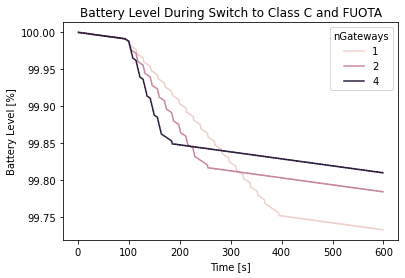

In [15]:
%matplotlib inline
sns.lineplot(data=results,
             x='Time [s]',
             y='Battery Level [%]',
            hue='nGateways')
plt.title("Battery Level During Switch to Class C and FUOTA")
plt.savefig('battery-level.pdf', bbox_inches='tight')
plt.show()

In [16]:
@sem.utils.output_labels(['Time [s]', 'Cumulative Received Bytes'])
@sem.utils.yields_multiple_results
def get_cumulative_bytes(result):
    samples = []
    running_sum = 0
    for row in result['output']['ReceivedBytes'].splitlines():
        time, context, received_bytes = [float(i) for i in row.strip().split(" ")]
        time = time/1e9
        if context == 0.0:
            running_sum += received_bytes
            samples += [[time, running_sum]]
    samples = [[0, 0], [samples[0][0]-0.001, 0]] + samples
    samples += [[1000, running_sum]]
    return samples

In [17]:
results = campaign.get_results_as_dataframe(get_cumulative_bytes)
#print(results[results['nGateways']==1])

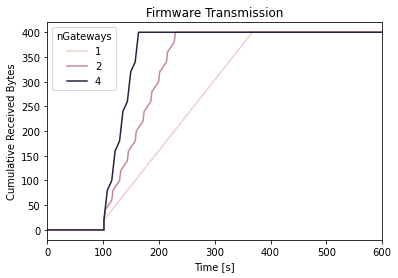

In [18]:
%matplotlib inline
sns.lineplot(data=results,
            x='Time [s]',
            y='Cumulative Received Bytes',
            hue='nGateways')
plt.xlim([0, 600])
plt.title("Firmware Transmission")
plt.savefig('cumulative-bytes.pdf', bbox_inches='tight')
plt.show()